In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
from scipy import stats , signal
from sklearn.cluster import KMeans
from PIL import Image
import glob

In [19]:
plt.style.use('dark_background')

# Load Data


In [ ]:

file = "BitCoin_MarketData.csv"
btc_data = pd.read_csv(file , parse_dates=['Unnamed: 0'])
btc_data.rename(columns={'Unnamed: 0' : 'Date'} , inplace=True)
date = btc_data.pop('Date')
btc_data.index = date
btc_data['return'] = btc_data['close'].pct_change(periods=50)
btc_data['mvg-2'] = btc_data['close'].rolling(11).mean()


In [21]:
btc_data.head()

,volume,vm,open,close,high,low,n,support,resistance,MVG,return,mvg-2
Date,,,,,,,,,,,,
2024-01-31 00:00:00,125.161195,43031.6293,42955.00,43040.10,43116.79,42916.72,1563.0,42932.283333,43132.353333,43040.100000,NaN,NaN
2024-01-31 00:05:00,56.174488,43030.6554,43001.76,43022.86,43061.39,43000.74,907.0,42995.270000,43055.920000,43031.307600,NaN,NaN
2024-01-31 00:10:00,27.061999,43030.7063,43022.89,43024.31,43069.00,43010.31,911.0,43000.080000,43058.770000,43028.881156,NaN,NaN
2024-01-31 00:15:00,107.263442,42943.8102,43023.03,42863.17,43040.00,42853.64,1756.0,42797.873333,42984.233333,42984.935233,NaN,NaN
2024-01-31 00:20:00,102.964504,42983.4083,42864.77,43036.05,43071.00,42854.13,1596.0,42903.120000,43119.990000,42995.992041,NaN,NaN


<Axes: title={'center': 'Main Data (Bitcoin Chart)'}, xlabel='Date'>

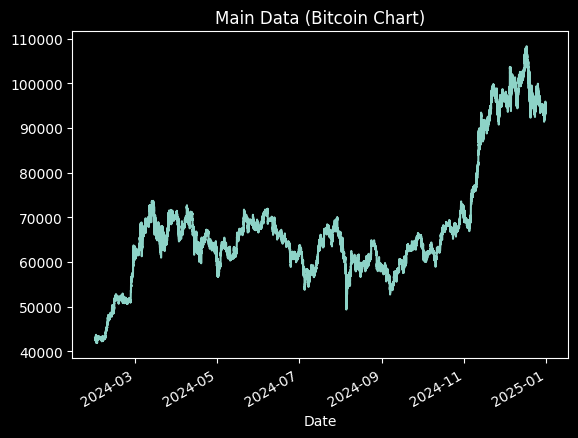

In [22]:
plt.title('Main Data (Bitcoin Chart)')
btc_data['close'].plot()

# Adjust Z-Normalization On Data
mean 0 , standard deviation 1

In [23]:

def adjust_z_normalazation(data) :
    
    data = np.array(data)
    std_dev = np.sqrt(np.sum((data - data.mean())**2) / len(data))
    z_score = (data - data.mean()) / std_dev

    return z_score


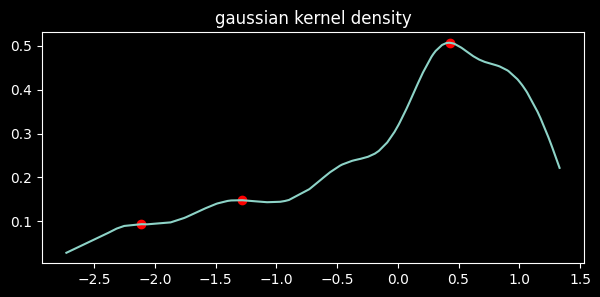

In [24]:

window_size = 50
rn = np.random.randint(len(btc_data))
spot = slice( rn- window_size , rn+window_size)

sequence = btc_data[spot]
norm_sequence = adjust_z_normalazation(sequence['close'])
high , low , open , close , mvg = adjust_z_normalazation(sequence['high']),adjust_z_normalazation(sequence['low']),adjust_z_normalazation(sequence['open']), norm_sequence , adjust_z_normalazation(sequence['mvg-2'])

kde = stats.gaussian_kde(sorted(norm_sequence), bw_method=0.2)

peaks = signal.find_peaks(kde(sorted(norm_sequence)))
kde_data = kde(sorted(norm_sequence))

plt.figure(figsize=(7,3))
plt.title('gaussian kernel density')
plt.scatter(np.array(sorted(norm_sequence))[peaks[0]],kde_data[peaks[0]] , c = 'red' )
plt.plot(sorted(norm_sequence),kde_data)


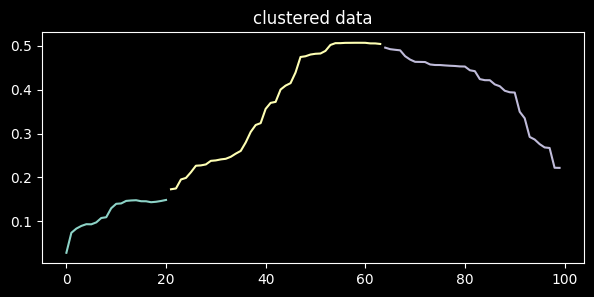

In [25]:
x,y = pd.Series(sorted(norm_sequence)) , pd.Series(kde_data).pct_change()

number_of_cluster = len(peaks[0])

label = list(KMeans(n_clusters=number_of_cluster).fit_predict(pd.concat([x,y],axis=1)[1:]))
label = list(label)
label.insert(0,label[0])

dt = pd.DataFrame({'x':kde_data , 'label' : label , 'main' : sorted(mvg)})

plt.figure(figsize=(7,3))
plt.title('clustered data')
for c in dt['label'].unique() :
    show_data , indx = dt[dt['label'] == c]['x'] , dt[dt['label'] == c]
    plt.plot(show_data)

In [26]:
dictionery = 'abcdefjh'

def get_symbols(data , dictionery) :
    dt = data.copy()
    lll = []
    for c in adjust_z_normalazation(sequence['mvg-2']) :
        try : 
            lll.append(int(dt[dt['main'] == c]['label']))
        except : 
            lll.append(int(dt[dt['main'] == c]['label'].values[0]))
    lst = lll
    result = []
    simplified_list = [key for key, _ in groupby(lst)]
    # result.append(lst[-1])
    # result = result[-1] if result[-1] == result[-2] else result

    return str(''.join([dictionery[i] for i in simplified_list])) , lst

C:\Users\PIP\AppData\Local\Temp\ipykernel_1888\2864867762.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  lll.append(int(dt[dt['main'] == c]['label']))


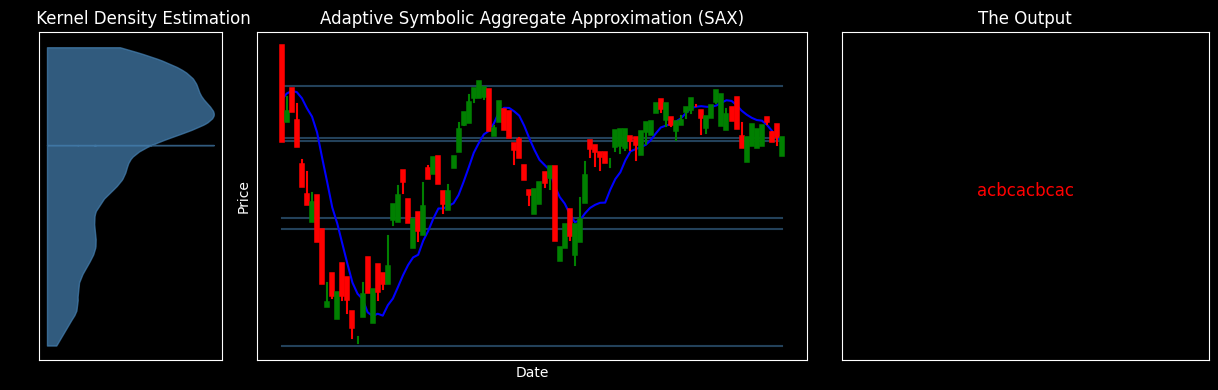

In [27]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 3 , 2]})

ax1 = axes[1]
for i in dt['label'].unique() :
    beta1 , beta2 = x[dt['label']==i].max() , x[dt['label']==i].min()
    ax1.plot(sequence.index,[beta1]*len(norm_sequence), alpha=0.5, color='steelblue')
    ax1.plot(sequence.index,[beta2]*len(norm_sequence), alpha=0.5, color='steelblue')

ax1.plot(sequence.index, mvg , color = 'blue')

for i in range(len(sequence)):
    color = 'g' if close[i] >= open[i] else 'r'
    ax1.plot([sequence.index[i], sequence.index[i]], [low[i], high[i]], color=color, lw=1.5)
    ax1.plot([sequence.index[i], sequence.index[i]], [open[i], low[i]], color=color, lw=4)

ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title("Adaptive Symbolic Aggregate Approximation (SAX)")
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = axes[0]
ax2.fill_between([0] + list(dt['x']) + [0],[sorted(norm_sequence)[0]]+sorted(norm_sequence)+[sorted(norm_sequence)[-1]], color='steelblue', alpha=0.7)
ax2.set_title("     Kernel Density Estimation")
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = axes[2]

encoded_chart , lst = get_symbols(dt,dictionery)

ax3.set_title('The Output')
ax3.text(x = 0.5 ,y = 0.5 ,s = encoded_chart, fontsize=12, color='red', ha='center')
ax3.set_xticks([])
ax3.set_yticks([])
plt.tight_layout()
plt.show()


In [ ]:
for iii in range(100,500) :
    window_size = 50
    rn = iii
    spot = slice( rn- window_size , rn+window_size)

    sequence = btc_data[spot]
    norm_sequence = adjust_z_normalazation(sequence['close'])
    high , low , open , close , mvg = adjust_z_normalazation(sequence['high']),adjust_z_normalazation(sequence['low']),adjust_z_normalazation(sequence['open']), norm_sequence , adjust_z_normalazation(sequence['mvg-2'])

    kde = stats.gaussian_kde(sorted(norm_sequence), bw_method=0.19)

    peaks = signal.find_peaks(kde(sorted(norm_sequence)))
    kde_data = kde(sorted(norm_sequence))

    x,y = pd.Series(sorted(norm_sequence)) , pd.Series(kde_data).pct_change()

    number_of_cluster = len(peaks[0])

    label = list(KMeans(n_clusters=number_of_cluster).fit_predict(pd.concat([x,y],axis=1)[1:]))
    label = list(label)
    label.insert(0,label[0])

    dt = pd.DataFrame({'x':kde_data , 'label' : label , 'main' : sorted(mvg)})

    for c in dt['label'].unique() :
        show_data , indx = dt[dt['label'] == c]['x'] , dt[dt['label'] == c]
        plt.plot(show_data)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 3 , 2]})

    ax1 = axes[1]
    for i in dt['label'].unique() :
        beta1 , beta2 = x[dt['label']==i].max() , x[dt['label']==i].min()
        ax1.plot(sequence.index,[beta1]*len(norm_sequence), alpha=0.5, color='steelblue')
        ax1.plot(sequence.index,[beta2]*len(norm_sequence), alpha=0.5, color='steelblue')

    ax1.plot(sequence.index, mvg , color = 'blue')

    for i in range(len(sequence)):
        color = 'g' if close[i] >= open[i] else 'r'
        ax1.plot([sequence.index[i], sequence.index[i]], [low[i], high[i]], color=color, lw=1.5)
        ax1.plot([sequence.index[i], sequence.index[i]], [open[i], low[i]], color=color, lw=4)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price")
    ax1.set_title("Adaptive Symbolic Aggregate Approximation (SAX)")
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = axes[0]
    ax2.fill_between([0] + list(dt['x']) + [0],[sorted(norm_sequence)[0]]+sorted(norm_sequence)+[sorted(norm_sequence)[-1]], color='steelblue', alpha=0.7)
    ax2.set_title("     Kernel Density Estimation")
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3 = axes[2]

    encoded_chart , lst = get_symbols(dt,dictionery)

    ax3.set_title('The Output')
    ax3.text(x = 0.5 ,y = 0.5 ,s = encoded_chart, fontsize=12, color='red', ha='center')
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.tight_layout()
    plt.close()
    print(iii)
    fig.savefig(rf'sample{iii}.png')


In [ ]:
image_files = sorted(glob.glob("sample*.png"))  

images = [Image.open(img) for img in image_files]
images[0].save("animation_.gif", save_all=True, append_images=images[1:], duration=43, loop=0)
